# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [1]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [2]:
from pkg.cross_attention import NLBlockND

In [3]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '090601oci'  # Copy name from the model training file
exp = 't'

In [4]:
max_value = 2.5
min_value = -2.0

## Load data

In [5]:
X_train_t = torch.load(f'data/X_train_{exp}.pt')
y_train_t = torch.load(f'data/y_train_{exp}.pt')

X_val_t = torch.load(f'data/X_val_{exp}.pt')
y_val_t = torch.load(f'data/y_val_{exp}.pt')

X_test_t = torch.load(f'data/X_test_{exp}.pt')
y_test_t = torch.load(f'data/y_test_{exp}.pt')

# Network

In [6]:
class Hierarchy(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
    )
      
    self.cls1 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )
    self.cls2 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )
    self.cls31 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
    )
    self.cls32 = nn.Sequential (
      nn.Linear(128, 3),
      nn.Sigmoid(),
    )

    self.reg1 = nn.Sequential (
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
    )
    self.cross_attn = nn.Sequential(
      NLBlockND(in_channels=128, dimension=2, bn_layer=False),
    )
    self.reg2 = nn.Sequential (
      nn.Linear(128, 1),
    )

    self.recon = nn.Sequential (
      nn.Linear(32, 128),
      nn.ReLU(),
      nn.Linear(128, input_size),
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    feature = self.encoder(x)
    classification1 = self.cls1(feature)
    mask_cloudy = torch.where(classification1<=0.5, 1, 0)
    x_cloudy =  feature * mask_cloudy
    classification2 = self.cls2(x_cloudy)
    class3_feature = self.cls31(x_cloudy)
    classification3 = self.cls32(class3_feature)
    regression_feature = self.reg1(x_cloudy)
    attn_feature = self.cross_attn((regression_feature, class3_feature))
    regression = self.reg2(attn_feature)
    reconstruction = self.recon(feature)

    return reconstruction, classification1, classification2, classification3, mask_cloudy, regression

## Load model

In [7]:
model = Hierarchy(input_size=X_train_t.shape[1])
model.load_state_dict(torch.load('./models/{}_min_valid_loss.pth'.format(expname), map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('/Users/xingyanli/Lab/gestar2_regression/hierarchical_class/models/070511oci_107_min_valid_loss.pth'))

<All keys matched successfully>

In [8]:

# Test data loader
dataset_test = Data.TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(dataset = dataset_test, batch_size = len(y_test_t), shuffle=False, pin_memory=True)

# Load model
for step, (d_x,d_y) in enumerate(test_loader):
    recon, output_cls1_test, output_cls2_test, output_cls3_test, cloud_mask_test, output_reg_test = model(d_x)
    output_reg_test = output_reg_test*(max_value-min_value)+min_value
    cloud_n = torch.sum(cloud_mask_test)

    ground_truth_cls1_test = torch.reshape(d_y[:,0], [-1,1]) # Cloud-free = 1, Cloudy = 0
    ground_truth_cls2_test = torch.reshape(d_y[:,1], [-1,1]) # Liquid = 1, Ice = 0
    ground_truth_reg_test = torch.reshape(d_y[:,3], [-1,1])
    ground_truth_reg_test = ground_truth_reg_test*(max_value-min_value)+min_value

output_cls1_test = output_cls1_test.detach().cpu().numpy()
output_cls2_test = output_cls2_test.detach().cpu().numpy()
output_reg_test = output_reg_test.detach().cpu().numpy()
ground_truth_cls1_test = ground_truth_cls1_test.detach().cpu().numpy()
ground_truth_cls2_test = ground_truth_cls2_test.detach().cpu().numpy()
ground_truth_reg_test = ground_truth_reg_test.detach().cpu().numpy()
cloud_mask_test = cloud_mask_test.detach().cpu().numpy()
X_test_t = X_test_t.detach().cpu().numpy()
cloud_n = cloud_n.detach().cpu().numpy()

file = open("results/{}oci_log.txt".format(expname),"a")



## Evaluation of classifiction task

Evaluation metrics:
- Confusion matrix
- Accuracy
- Precision, Recall for each class

In [9]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [10]:
y_pred = np.where(output_cls1_test>0.5, 0, 1) # Cloudy = 1, cloud-free = 0
y_true = np.where(ground_truth_cls1_test==0, 1,0)
y_pred2 = np.where(output_cls2_test>0.5, 1, 0)
y_true2 = ground_truth_cls2_test

In [11]:
print(25000-np.sum(ground_truth_cls1_test), np.sum(y_pred)) # True #cloudy pixels and predicted #cloudy pixels

17418.0 17461


In [12]:
np.sum(y_pred) == cloud_n

True

In [13]:
# Three labels 
y_pred_3c = []
y_true_3c = []
for i in range (len(y_pred)):
    if y_pred[i] == 0:
        y_pred_3c.append(0)
    elif y_pred[i] == 1:
        if y_pred2[i] ==1:
            y_pred_3c.append(1)
        elif y_pred2[i] ==0:
            y_pred_3c.append(2)
for i in range (len(y_true)):
    if y_true[i] == 0:
        y_true_3c.append(0)
    elif y_true[i] == 1:
        if y_true2[i] ==1:
            y_true_3c.append(1)
        elif y_true2[i] ==0:
            y_true_3c.append(2)
y_pred_3c = np.array(y_pred_3c)
y_true_3c = np.array(y_true_3c)

In [14]:
# Load data for each surface type in albedo = [land, snow, desert, ocean_water]
y_pred_surface = []
y_true_surface = []
albedo_string = ['land', 'snow', 'desert', 'ocean_water']
for m in range(len(albedo_string)):
    y_pred_mth_surface = []
    y_true_mth_surface = []
    i = 0
    for i in range(len(X_test_t)):
        if X_test_t[i,226+m] == 1:
            y_pred_mth_surface.append(np.float(y_pred_3c[i]))
            y_true_mth_surface.append(np.float(y_true_3c[i]))
    y_pred_surface.append(y_pred_mth_surface)
    y_true_surface.append(y_true_mth_surface)

/var/folders/bk/np_scrln11196kgfc476_rpc0000gn/T/ipykernel_11808/3586996066.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_mth_surface.append(np.float(y_pred_3c[i]))
/var/folders/bk/np_scrln11196kgfc476_rpc0000gn/T/ipykernel_11808/3586996066.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true_mth_surface.append(np.flo

### Metrics for (cloudy, cloud-free) binary classification
- Precision = TP/ (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 * (Precison * Recall / (Precision + Recall))
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Confusion matrix

In [15]:
accuracy_bi = accuracy_score(y_true, y_pred)
f1_score_bi = f1_score(y_true, y_pred)
precision_bi = precision_score(y_true, y_pred)
recall_bi = recall_score(y_true, y_pred)

print(f'Accuracy - binary classification: {accuracy_bi: .3f}')
print(f'F1 - binary classification: {f1_score_bi: .3f}')
print(f'Recall - binary classification: {recall_bi: .3f}')
print(f'Precision - binary classification: {precision_bi: .3f}')


Accuracy - binary classification:  0.984
F1 - binary classification:  0.989
Recall - binary classification:  0.990
Precision - binary classification:  0.987


### Recall, accuracy, F1 score, precision for each label
- Precision = TP/ (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 * (Precison * Recall / (Precision + Recall))
- Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [16]:
y_pred2 = y_pred2[np.where(y_pred==1)]
y_true2 = y_true2[np.where(y_pred==1)]

In [17]:
# Precision, Recall for each class

precision_1 = precision_score(y_true2, y_pred2)
recall_1 = recall_score(y_true2, y_pred2)

precision_2 = precision_score(np.where(y_true2==1, 0, 1), np.where(y_pred2==1, 0, 1))
recall_2 = recall_score(np.where(y_true2==1, 0, 1), np.where(y_pred2==1, 0, 1))

print(f'Recall - liquid: {recall_1: .3f}')
print(f'Precision - liquid: {precision_1: .3f}')

print(f'Recall - ice crystal: {recall_2: .3f}')
print(f'Precision - ice crystal: {precision_2: .3f}')

Recall - liquid:  0.985
Precision - liquid:  0.981
Recall - ice crystal:  0.982
Precision - ice crystal:  0.985


### Confusion matrix

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from pkg.cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [19]:
categories = ['Cloud-free', 'Liquid', 'Ice-crystal']

### Area under the precision recall curve

In [20]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from itertools import cycle
from collections import Counter

In [21]:
multi_labels = ['cloudy', 'cloud-free', 'liquid', 'ice']
cloudy_pred_1hot = (1-np.reshape(output_cls1_test, -1)) #cloudy
cloudfree_pred_1hot = np.reshape(output_cls1_test, -1) #cloudy-free
liquid_pred_1hot = np.reshape(output_cls2_test, -1)
ice_pred_1hot = (1-np.reshape(output_cls2_test, -1))
liquid_pred_1hot = np.where(cloudfree_pred_1hot>0.5, 0, liquid_pred_1hot)
ice_pred_1hot = np.where(cloudfree_pred_1hot>0.5, 0, ice_pred_1hot)

cloudy_true_1hot = (1-np.reshape(ground_truth_cls1_test, -1)) #cloudy
cloudfree_true_1hot = np.reshape(ground_truth_cls1_test, -1) #cloudy-free
liquid_true_1hot = np.reshape(ground_truth_cls2_test, -1)
ice_true_1hot = (np.array(y_test_t[:, 2]))

In [22]:
y_pred_1hot = np.stack((cloudy_pred_1hot, cloudfree_pred_1hot, liquid_pred_1hot, ice_pred_1hot), axis=-1)
y_true_1hot = np.stack((cloudy_true_1hot, cloudfree_true_1hot, liquid_true_1hot, ice_true_1hot), axis=-1)

In [23]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_true_1hot[:, i], y_pred_1hot[:, i])
    average_precision[i] = average_precision_score(y_true_1hot[:, i], y_pred_1hot[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_1hot.ravel(), y_pred_1hot.ravel()
)
average_precision["micro"] = average_precision_score(y_true_1hot, y_pred_1hot, average="micro")

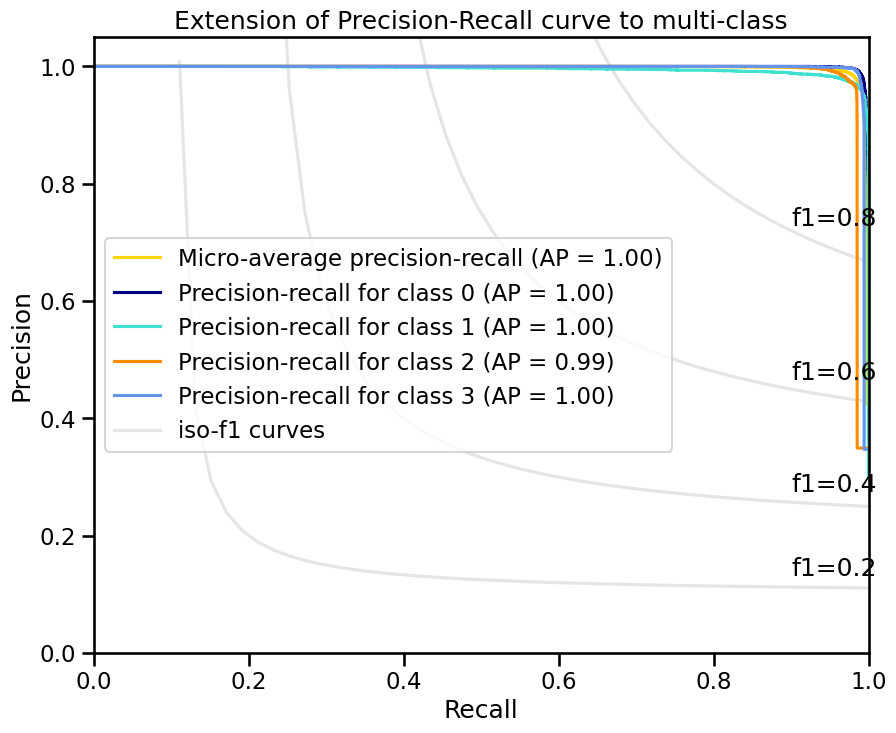

In [24]:
from itertools import cycle

colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(10,8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(4), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [25]:
average_precision

{0: 0.9992933020878928,
 1: 0.995159386773546,
 2: 0.9896505952960544,
 3: 0.9958678235282301,
 'micro': 0.9964322249632509}

## Evaluation of regression task

Evaluation metrics:
- MSE, RMSE
- R-squared (coefficient of determination)
- Bins

In [26]:
from sklearn.metrics import r2_score

In [27]:
# Filter cloud-free pixels. Only evaluate over cloudy pixels
y_mask = np.where(y_true_3c>=1, 1, 0)
y_mask = np.where(y_pred_3c>=1, y_mask, 0)

### Overall regression results

In [28]:
# 
y_pred_reg = []
y_true_reg = []

for i in range(len(y_mask)):
    if y_mask[i]==1:
        y_pred_reg.append(output_reg_test[i])
        y_true_reg.append(ground_truth_reg_test[i])
y_pred_reg = np.array(y_pred_reg)
y_true_reg = np.array(y_true_reg)

In [29]:
MSE = np.square(np.subtract(y_true_reg,y_pred_reg)).mean()
RMSE = math.sqrt(MSE)
r2 = r2_score(y_true_reg, y_pred_reg)
file.write(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f}, R2: {r2: .3f} \n') 
print(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f} \n')
print(f'R2 score: {r2: .3F} \n')

MSE:  0.026, RMSE:  0.163 

R2 score:  0.891 



### Regression results for each label

In [30]:
# Load COT data for each label in [cloud-free, liquid, ice crystal]
y_pred_reg_liquid = []
y_true_reg_liquid = []
y_pred_reg_ice = []
y_true_reg_ice = []

for i in range(len(output_reg_test)):
    if y_mask[i] == 1:
        if y_true_3c[i] == 1:
            y_pred_reg_liquid.append(output_reg_test[i])
            y_true_reg_liquid.append(ground_truth_reg_test[i])
        if y_true_3c[i] == 2:
            y_pred_reg_ice.append(output_reg_test[i])
            y_true_reg_ice.append(ground_truth_reg_test[i])

In [31]:
MSE_liquid = np.square(np.subtract(np.array(y_true_reg_liquid),np.array(y_pred_reg_liquid))).mean()
RMSE_liquid = math.sqrt(MSE_liquid)
r2_liquid = r2_score(np.array(y_true_reg_liquid), np.array(y_pred_reg_liquid))
print('Liquid:')
file.write(f'MSE: {MSE_liquid: .3F}, RMSE: {RMSE_liquid: .3f}, R2: {RMSE_liquid: .3f} \n') 
print(f'MSE: {MSE_liquid: .3F}, RMSE: {RMSE_liquid: .3f}')
print(f'R2 score: {r2_liquid: .3F} \n')

MSE_ice = np.square(np.subtract(np.array(y_true_reg_ice),np.array(y_pred_reg_ice))).mean()
RMSE_ice = math.sqrt(MSE_ice)
r2_ice = r2_score(np.array(y_true_reg_ice), np.array(y_pred_reg_ice))
print('Ice:')
file.write(f'MSE: {MSE_ice: .3F}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n') 
print(f'MSE: {MSE_ice: .3F}, RMSE: {RMSE_ice: .3f} ')
print(f'R2 score: {r2_ice: .3F} \n')

Liquid:
MSE:  0.032, RMSE:  0.179
R2 score:  0.869 

Ice:
MSE:  0.021, RMSE:  0.145 
R2 score:  0.914 



In [32]:
y_true_reg_liquid_cot5 = np.reshape(np.array(y_true_reg_liquid), -1)[np.where(np.reshape(np.array(y_true_reg_liquid), -1)>math.log(5, 10))]
y_pred_reg_liquid_cot5 = np.reshape(np.array(y_pred_reg_liquid), -1)[np.where(np.reshape(np.array(y_true_reg_liquid), -1)>math.log(5, 10))]
y_true_reg_ice_cot5 = np.reshape(np.array(y_true_reg_ice), -1)[np.where(np.reshape(np.array(y_true_reg_ice), -1)>math.log(5, 10))]
y_pred_reg_ice_cot5 = np.reshape(np.array(y_pred_reg_ice), -1)[np.where(np.reshape(np.array(y_true_reg_ice), -1)>math.log(5, 10))]

In [33]:
y_true_reg_liquid_cot5 = np.power(10, y_true_reg_liquid_cot5)
y_pred_reg_liquid_cot5 = np.power(10, y_pred_reg_liquid_cot5)
y_true_reg_ice_cot5 = np.power(10, y_true_reg_ice_cot5)
y_pred_reg_ice_cot5 = np.power(10, y_pred_reg_ice_cot5)

In [34]:
uncertainty_liquid = np.abs(np.reshape(np.array(y_pred_reg_liquid_cot5), -1) - np.reshape(np.array(y_true_reg_liquid_cot5), -1)) / np.reshape(np.array(y_true_reg_liquid_cot5), -1)
ratio_liquid_goal = np.sum(np.where(uncertainty_liquid<=0.3, 1, 0))/len(y_true_reg_liquid_cot5)

uncertainty_ice = np.abs(np.reshape(np.array(y_pred_reg_ice_cot5), -1) - np.reshape(np.array(y_true_reg_ice_cot5), -1)) / np.reshape(np.array(y_true_reg_ice_cot5), -1)
ratio_ice_goal = np.sum(np.where(uncertainty_ice<=0.35, 1, 0))/len(y_true_reg_ice_cot5)
print(f"Liquid: {ratio_liquid_goal:.2%}, Ice: {ratio_ice_goal:.2%}")

Liquid: 67.96%, Ice: 82.70%


### Regression results for each surface type

In [35]:
y_pred_reg_surface = []
y_true_reg_surface = []
for m in range(len(albedo_string)):
    y_pred_reg_surface.append(output_reg_test[np.where((y_mask==1)&((X_test_t[:,226+m]==1)))])
    y_true_reg_surface.append(ground_truth_reg_test[np.where((y_mask==1)&(X_test_t[:,226+m]==1))])

In [36]:
for i in range(len(albedo_string)):
    MSE_surface = np.square(np.subtract(y_true_reg_surface[i], y_pred_reg_surface[i])).mean()
    RMSE_ice = math.sqrt(MSE_surface)
    r2_ice = r2_score(y_true_reg_surface[i], y_pred_reg_surface[i])
    print(f'{albedo_string[i]}:')
    print(f'MSE: {MSE_surface: .3f}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n')
    file.write(f'MSE: {MSE_surface: .3f}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n') 

land:
MSE:  0.023, RMSE:  0.152, R2:  0.904 

snow:
MSE:  0.034, RMSE:  0.183, R2:  0.861 

desert:
MSE:  0.027, RMSE:  0.165, R2:  0.895 

ocean_water:
MSE:  0.025, RMSE:  0.159, R2:  0.898 



### Bins of R-2 and Accuracy
Bins divided by [thin, moderate, thick] or TRUE COT values [-1.5~0, 0~1, 1~2.5]

In [37]:
# Divided the regression outputs and classification outputs by bins
bin_category = ['thin', 'moderate', 'thick']
bin_division = [-1.5, 0, 1, 2.5]
y_true_bins = []
y_pred_bins = []
y_true_reg_bins = []
y_pred_reg_bins = []
# Classification predictions and true values
for i in range(len(bin_category)):
    y_true_bins.append(y_true_3c[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1]))])
    y_pred_bins.append(y_pred_3c[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1]))])
    y_true_reg_bins.append(ground_truth_reg_test[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1])&(y_pred_3c>0))])
    y_pred_reg_bins.append(output_reg_test[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1])&(y_pred_3c>0))])

In [38]:
# Calculate accuracy for each bin
accuracy_bins = []
r2_bins = []
for i in range(len(bin_category)): 
    accuracy_bins.append(accuracy_score(y_true_bins[i], y_pred_bins[i]))
    r2_bins.append(r2_score(y_true_reg_bins[i], y_pred_reg_bins[i]))
print(accuracy_bins, r2_bins)

[0.8860439956725568, 0.9974677133451507, 1.0] [-0.2792042393181706, 0.7328288358113683, 0.33943397074994286]


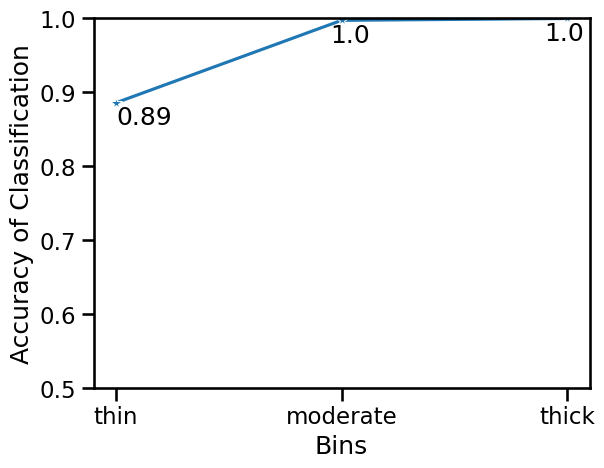

In [39]:
g = sns.lineplot(x=bin_category, y=accuracy_bins, marker='*')
g.set_ylim(0.5, 1)
g.set(xlabel='Bins', ylabel='Accuracy of Classification')
i=0
# label points on the plot
for x, y in zip(bin_category, accuracy_bins):
    plt.text(x = i*0.19, y = y-0.03, s = '{:.2}'.format(y))
    i=i+5
plt.savefig("./results/{}_binaccu.png".format(expname),bbox_inches = 'tight')

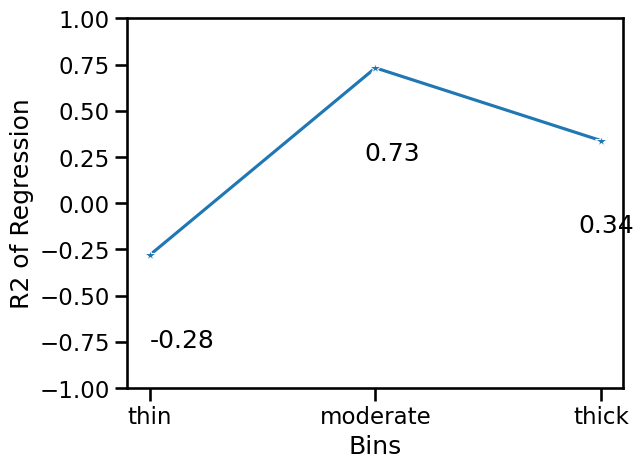

In [40]:
g = sns.lineplot(x=bin_category, y=r2_bins, marker='*')
g.set_ylim(-1, 1)
g.set(xlabel='Bins', ylabel='R2 of Regression')
i=0
# label points on the plot
for x, y in zip(bin_category, r2_bins):
    plt.text(x = i*0.19, y = y-0.5, s = '{:.2}'.format(y))
    i=i+5
plt.savefig("./results/{}_binr2.png".format(expname),bbox_inches = 'tight')

### Scatter plot

In [41]:
sns.set_context('notebook')

In [42]:
cot_each_label = y_true_3c[np.where((y_true_3c>0)&(y_pred_3c>0))]
cot_each_label = np.where(cot_each_label==1, 'Liquid', 'Ice_crystal')
cot_each_label = np.array(cot_each_label,dtype='object')

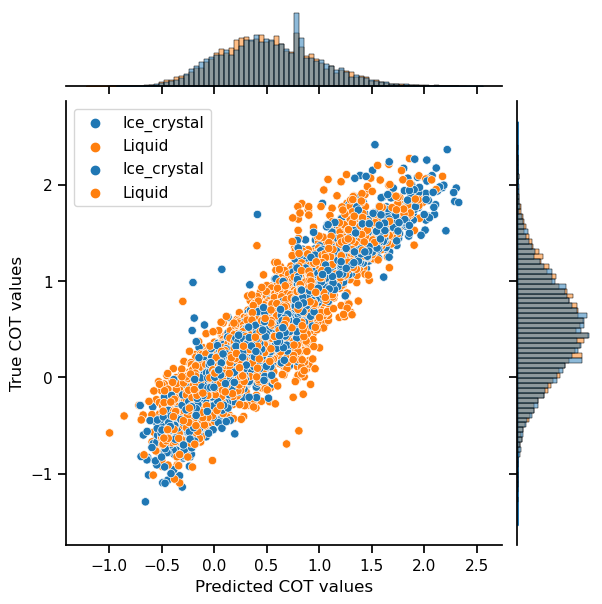

In [43]:
g = sns.jointplot(x=np.reshape(y_pred_reg,-1), y=np.reshape(y_true_reg,-1), hue=cot_each_label)
g.set_axis_labels('Predicted COT values', 'True COT values')
g.plot(sns.scatterplot, sns.histplot)
plt.savefig("./results/{}_scatter.png".format(expname),bbox_inches = 'tight')

### Hexbin plot

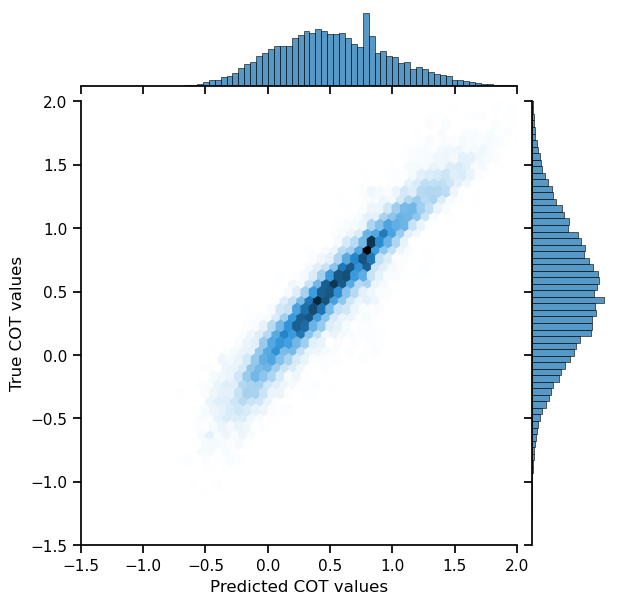

In [44]:
g = sns.jointplot(x=np.reshape(y_pred_reg,-1), y=np.reshape(y_true_reg,-1), kind="hex")
g.set_axis_labels('Predicted COT values', 'True COT values')
g.ax_marg_x.set_xlim(-1.5, 2)
g.ax_marg_y.set_ylim(-1.5, 2)
plt.savefig("./results/{}_hexbin.png".format(expname), bbox_inches = 'tight')